In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, minimize
from scipy.stats import gaussian_kde

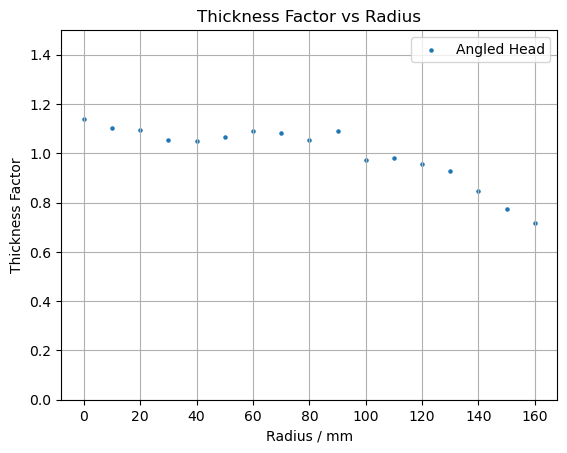

In [5]:
# Data
radii = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
thickness_factors1 = [1.138, 1.101, 1.096, 1.055, 1.05, 1.065, 1.091, 1.081, 1.055, 1.091, 0.972, 0.982, 0.956, 0.93, 0.847, 0.774, 0.717]
thickness_factors2 = [1.043, 1.031, 1.062, 1.019, 1.068, 1.056, 1.056, 1.056, 1.037, 1.037, 1.05, 0.995, 0.952, 0.964, 0.897, 0.866, 0.812]

radii = np.array(radii)
thickness_factors_1 = np.array(thickness_factors1)
thickness_factors2 = np.array(thickness_factors2)

plt.scatter(radii, thickness_factors1, s=5, label='Angled Head')
# plt.scatter(radii, thickness_factors2, s=5, label='Vertical Head')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.show()

In [6]:
# Fit with a custom function: a1/(1+exp(-b1*(x-c1))) + a2/(1+exp(-b2*(x-c2)) + d
def curve_func(x, a1, b1, c1, a2, b2, c2, d):
    return a1/(1+np.exp(-b1*(x-c1))) + a2/(1+np.exp(-b2*(x-c2))) + d

def get_coeffs(radii, thickness_factors):
    initial_guesses = [0.25, 0.1, 50, -0.55, 0.08, 50, 1.0]
    popt, pcov = curve_fit(curve_func, radii, thickness_factors, p0=initial_guesses, maxfev=5000)
    print(f'Equation: {popt[0]:.2f}/(1+exp(-{popt[1]:.2f}*(x-{popt[2]:.2f}))) + {popt[3]:.2f}/(1+exp(-{popt[4]:.2f}*(x-{popt[5]:.2f}))) + {popt[6]:.2f}')
    return popt

# Get coefficients for both sets of data
coeffs1 = get_coeffs(radii, thickness_factors1)
coeffs2 = get_coeffs(radii, thickness_factors2)

# Get curve fit data
r = np.arange(0, 176, 0.1)
tf1 = curve_func(r, *coeffs1)
tf2 = curve_func(r, *coeffs2)

plt.scatter(radii, thickness_factors1, s=5, label='Angled Head')
plt.scatter(radii, thickness_factors2, s=5, label='Vertical Head')
plt.plot(r, tf1, label='Angled Head Fit')
plt.plot(r, tf2, label='Vertical Head Fit')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

#### Find optimal ratio to minimise flatness across entire plane

In [ ]:
# Minimise flatness
def objective(ratio):
    tfs = ratio*tf1 + (1-ratio)*tf2
    mse = np.mean((tfs - 1)**2)
    return mse

res = minimize(objective, 0.5, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
r_optp = res.x[0]

def curve_rsum(r, ratio):
    return ratio*curve_func(r, *coeffs1) + (1-ratio)*curve_func(r, *coeffs2)

# Plot flatness
r = np.arange(0, 176, 0.1)
tf1 = curve_func(r, *coeffs1)
tf2 = curve_func(r, *coeffs2)
tfs = curve_rsum(r, r_optp)

plt.scatter(radii, thickness_factors1, s=5, label='Angled Head')
plt.scatter(radii, thickness_factors2, s=5, label='Vertical Head')
plt.plot(r, tf1, label='Angled Head Fit')
plt.plot(r, tf2, label='Vertical Head Fit')
plt.plot(r, tfs, label=f'Flatness Fit: {res.x[0]:.2f} Angled, {1-res.x[0]:.2f} Vertical', c='r')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.title(f'Thickness Factor vs Radius\nOptimal Ratio (Plane): {r_optp:.2f}:{1-r_optp:.2f}')
plt.legend()
plt.grid()
plt.show()

#### Plot thickness profile

In [ ]:
# Constants
PLATE_X = 237.62
PLATE_Y = 237.62
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

In [ ]:
# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_ = curve_rsum(np.sqrt((xx_-CENTER_X)**2 + (yy_-CENTER_Y)**2), r_optp)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Thickness Factor')
ax.set_zlim(0, 1.5)
ax.set_title(f'Plasma Sputterer Coating Thickness Map\n Optimal Ratio (Plane): {r_optp:.2f}:{1-r_optp:.2f}')

plt.show()

#### Applying function to target points on tape

In [ ]:
# Get target numbers
n = np.arange(1, 181)
arg_n = np.where(((n-1) // 12) % 2 == 1, 0, 1)
front_n = n[arg_n == 1]
back_n = n[arg_n == 0]

# Read the data from the csv file
front_data = np.genfromtxt("front_data.csv", delimiter=",")
front_x = front_data[:, 0]
front_y = -front_data[:, 1] # Flip the y values cause drawing coordinate is upside down

back_data = np.genfromtxt("back_data.csv", delimiter=",")
back_x = back_data[:, 0]
back_y = -back_data[:, 1] # Flip the y values cause drawing coordinate is upside down

# Get distance of targets from center
front_radii = np.sqrt((front_x - CENTER_X) ** 2 + (front_y - CENTER_Y) ** 2)
back_radii = np.sqrt((back_x - CENTER_X) ** 2 + (back_y - CENTER_Y) ** 2)

merged_radii = []
for i in range(0, len(front_radii), 12):
    merged_radii.extend(front_radii[i:i+12])
    merged_radii.extend(back_radii[i:i+12])

# Get thickness factors
front_tf = curve_rsum(front_radii, r_optp)
back_tf = curve_rsum(back_radii, r_optp)
target_tf = curve_rsum(merged_radii, r_optp)

In [ ]:
# Create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Target Location Plot
for i, nn in enumerate(front_n):
    if (nn+11) % 12 == 0:
        ax1.annotate(nn, (front_x[i], -front_y[i]+2*CENTER_Y), fontsize=8, xytext=(front_x[i], -front_y[i]+2*CENTER_Y+5), c='C0', ha='center')
for i, nn in enumerate(back_n):
    if (nn+11) % 12 == 0:
        ax1.annotate(nn, (back_x[i], -back_y[i]+2*CENTER_Y), fontsize=8, xytext=(back_x[i]+PLATE_X-17.5, -back_y[i]+2*CENTER_Y-10), c='C1', ha='center')

square_x = [0, PLATE_X, PLATE_X, 0, 0]
square_y = [0, 0, PLATE_Y, PLATE_Y, 0]
ax1.plot(square_x, square_y)
ax1.scatter(-front_x+PLATE_X, front_y, s=3, c='C0', label='Front') # Flip the x values for plotting only
ax1.scatter(back_x, back_y, s=3, c='C1', label='Back')
ax1.set_xlabel('X / mm')
ax1.set_ylabel('Y / mm')
ax1.axis("equal")
ax1.set_title('Target Locations')


# Target Point Radius Plot
for i in range(0, len(n), 12):
    ax2.annotate(str(i+1), (n[i], merged_radii[i]), fontsize=8, xytext=(n[i]+1.5, merged_radii[i]+0.75), ha='center', va='bottom')
ax2.annotate(str(180), (n[-1], merged_radii[-1]), fontsize=8, xytext=(n[-1]+1.5, merged_radii[-1]+0.75), ha='center', va='bottom')

ax2.scatter(front_n, front_radii, s=5)
ax2.scatter(back_n, back_radii, s=5)
ax2.plot(n, merged_radii, c='C2', alpha=0.25)
ax2.set_xlabel('Target Number')
ax2.set_ylabel('Radius / mm')
ax2.set_ylim(-10, np.max(merged_radii) + 15)
ax2.set_title('Radius vs. Target Number (Unraveled)')


In [ ]:
# Get distribution of distance from center
kde_radii = gaussian_kde(merged_radii)
plt.plot(n, kde_radii(n))
plt.xlabel('Radius / mm')
plt.ylabel('Distribution Density')
plt.ylim(0, 0.02)
plt.yticks(np.arange(0, 0.021, 0.005))
plt.title('Distribution of Targets in Radius')
plt.grid()
plt.show()

In [ ]:
# Add data labels to points
for i in range(0, len(n), 12):
    plt.annotate(str(i+1), (n[i], target_tf[i]), fontsize=8, xytext=(n[i]-2.2, target_tf[i]-0.055))
plt.annotate(str(180), (n[-1], target_tf[-1]), fontsize=8, xytext=(n[-1]-2.2, target_tf[-1]-0.055))

plt.xlabel('Target Point (Unraveled)')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.plot(n, target_tf, c='C2', alpha=0.25)
plt.scatter(front_n, front_tf, s=5)
plt.scatter(back_n, back_tf, s=5)
plt.title(f'Thickness Factor vs. Target Point (Unraveled)\nRatio: {r_optp:.2f}:{1-r_optp:.2f}')
plt.grid()
plt.show()

In [ ]:
TF_FLOOR = 0.85
TF_CEILING = 1.15

arg_ok = np.where((target_tf >= TF_FLOOR) & (target_tf <= TF_CEILING))[0]
arg_notok = np.where((target_tf < TF_FLOOR) | (target_tf > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok = target_tf[arg_ok]

n_notok = n[arg_notok]
target_tfnotok = target_tf[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok):.3f}   Std: {np.std(target_tfok):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok, s=3)
ax1.scatter(n_notok, target_tfnotok, s=3, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax1.set_title(f'Thickness Factor vs. Target Point (Capped)\nRatio: {r_optp:.2f}:{1-r_optp:.2f}')
ax1.grid()

box = ax2.boxplot(target_tfok, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok, showmeans=True)
ax2.set_xlim(0, 2)
ax2.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()
plt.show()

#### Investigating the effect of ratio on target point thickenss distribution

In [ ]:
# Get distribution of thickness factors
for i in np.arange(0, 1.25, 0.25):
    kde_tf = gaussian_kde(curve_rsum(merged_radii, i))
    std = np.std(curve_rsum(merged_radii, i))
    tfn = np.arange(0, 1.5, 0.01)
    plt.plot(tfn, kde_tf(tfn), label=f'Ratio: {i:.2f}:{1-i:.2f}   Std: {std:.3f}')
plt.xlabel('Thickness Factor')
plt.ylabel('Distribution Density')
plt.title('Distribution of Thickness Factors')
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.view_init(20, -70)

tfn_ = np.arange(0, 1.5, 0.025)
ratio_ = np.arange(0, 1, 0.025)
ttfn_, rratio_ = np.meshgrid(tfn_, ratio_)
kkde_ = np.zeros(ttfn_.shape)

for i in range(len(ratio_)):
    kde_tf = gaussian_kde(curve_rsum(merged_radii, ratio_[i]))
    for j in range(len(tfn_)):
        kkde_[i, j] = kde_tf(tfn_)[j]

ax.plot_surface(ttfn_, rratio_, kkde_, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('Thickness Factor')
ax.set_ylabel('Ratio')
ax.set_zlabel('Distribution Density')
ax.set_title('Distribution of Thickness Factors')
plt.show()


#### Minimising standard deviation of thickness distribution to find optimal ratio

In [ ]:
# Minimum standard deviation
def objective(ratio):
    tfs = curve_rsum(merged_radii, ratio)
    std = np.std(tfs)
    return std

res = minimize(objective, 0.2, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
r_opt = res.x[0]
print(f'Optimal Ratio: {r_opt:.5f}')

kde_tf = gaussian_kde(curve_rsum(merged_radii, r_opt))
median = np.median(curve_rsum(merged_radii, r_opt))
mean = np.mean(curve_rsum(merged_radii, r_opt))
std = np.std(curve_rsum(merged_radii, r_opt))

tfn = np.arange(0, 1.5, 0.01)
plt.plot(tfn, kde_tf(tfn))
plt.xlabel('Thickness Factor')
plt.ylabel('Density')
plt.title('Distribution of Targets in Thickness Factor\n' + f'Optimal Ratio (Targets): {r_opt:.3f}, Mean: {mean:.2f}, STD: {std:.2f}')
plt.grid()
plt.show()

# Plot flatness
r = np.arange(0, 176, 0.1)
tf1 = curve_func(r, *coeffs1)
tf2 = curve_func(r, *coeffs2)
tfs = curve_rsum(r, r_opt)

plt.scatter(radii, thickness_factors1, s=5, label='Angled Head')
plt.scatter(radii, thickness_factors2, s=5, label='Vertical Head')
plt.plot(r, tf1, label='Angled Head Fit')
plt.plot(r, tf2, label='Vertical Head Fit')
plt.plot(r, tfs, label=f'Flatness Fit: {res.x[0]:.2f} Angled, {1-res.x[0]:.2f} Vertical', c='r')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.title(f'Thickness Factor vs Radius\nOptimal Ratio (Targets): {r_opt:.2f}')
plt.legend()
plt.grid()
plt.show()

#### Applying Thickness Profile to Tape

In [ ]:
# Get thickness factors
front_tf = curve_rsum(front_radii, r_opt)
back_tf = curve_rsum(back_radii, r_opt)
target_tf = curve_rsum(merged_radii, r_opt)

In [ ]:
TF_FLOOR = 0.85
TF_CEILING = 1.15

arg_ok = np.where((target_tf >= TF_FLOOR) & (target_tf <= TF_CEILING))[0]
arg_notok = np.where((target_tf < TF_FLOOR) | (target_tf > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok = target_tf[arg_ok]

n_notok = n[arg_notok]
target_tfnotok = target_tf[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok):.3f}   Std: {np.std(target_tfok):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok, s=3)
ax1.scatter(n_notok, target_tfnotok, s=3, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax1.set_title(f'Thickness Factor vs. Target Point (Capped)\nRatio: {r_opt:.2f}:{1-r_opt:.2f}')
ax1.grid()

box = ax2.boxplot(target_tfok, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok, showmeans=True)
ax2.set_xlim(0, 2)
ax2.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()
plt.show()

In [ ]:
# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf})
df.to_csv('target_data_opt.csv', index=False)

# Load csv head
with open('target_data_opt.csv', 'r') as f:
    df = pd.read_csv(f)
print(df.head().to_string(index=False, justify='center'))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Thickness Factor vs Target Number Plot
for i in range(0, len(n), 12):
    ax1.annotate(str(i+1), (n[i], target_tf[i]), fontsize=8, xytext=(n[i]-1, target_tf[i]-0.02))
ax1.annotate(str(180), (n[-1], target_tf[-1]), fontsize=8, xytext=(n[-1]-1, target_tf[-1]-0.02))

ax1.scatter(front_n, front_tf, s=5)
ax1.scatter(back_n, back_tf, s=5)
ax1.plot(n, target_tf, c='C2', alpha=0.25)
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax1.set_title('Thickness Factor vs. Target Point (Unraveled)')
ax1.grid()

# Thickenss Factor Distribution Plot
box = ax2.boxplot(target_tf, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tf, showmeans=True)
ax2.set_xlim(0, 2)
ax2.set_ylim(np.min(target_tf)-0.05, np.max(target_tf)+0.05)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()
plt.show()

In [ ]:


class MplCanvas(FigureCanvasQTAgg):

    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)


